# Estimating alcohol content in red wines

* Author: Martin Rožnovják
* Last edited: 2019-02-11
* Organization: Metropolia University of Applied Sciences

## What is this?

This notebook is a school assignment for a course called *Cognitive Systems - Mathematics and Methods*.

Its objective is to conduct linear regression analysis on wine properties
from the following UCI dataset https://archive.ics.uci.edu/ml/datasets/Wine+Quality.

Personally, I prefer red wine over white so I'll analyze the red wine dataset.
I'll be interested in estimating the alcohol content of the wines instead
of their quality - just out of interest and objectivity of the measurements,
not because I'm a student... :)

## Let's begin
### All the necessary imports

In [1]:
import IPython

import scipy
import sklearn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics, preprocessing
from sklearn.linear_model import LinearRegression

Setting options, in particular those for plotting, often interferes with Jupyter's own initializations on import. Therefore, I just do it in the next cell.

In [2]:
### plotting ###
# prettier and larger basic graphs
sns.set(rc={
    'figure.figsize':(18,8),
    'axes.titlesize':14,
})

### pandas ###
# no need to see many decimal places and makes nicer horizontal fits :-)
pd.options.display.float_format = '{:.3f}'.format
# pd.options.display.precision = 3
# make the tables more compact vertically, too
pd.options.display.max_rows = 20

### numpy ###
# same as for pandas - max. 3 decimal places
np.set_printoptions(formatter={'float_kind':'{:.3f}'.format})
# np.set_printoptions(precision=3)

### Fetching the dataset

In [3]:
wines_df = pd.read_csv(
    r'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
    sep=';',
)

# a peek whether it went alright
wines_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.400,0.700,0.000,1.900,0.076,11.000,34.000,0.998,3.510,0.560,9.400,5
1,7.800,0.880,0.000,2.600,0.098,25.000,67.000,0.997,3.200,0.680,9.800,5
2,7.800,0.760,0.040,2.300,0.092,15.000,54.000,0.997,3.260,0.650,9.800,5
3,11.200,0.280,0.560,1.900,0.075,17.000,60.000,0.998,3.160,0.580,9.800,6
4,7.400,0.700,0.000,1.900,0.076,11.000,34.000,0.998,3.510,0.560,9.400,5


No need for the "quality" column, let's forget it...

In [4]:
wines_df.drop(columns=["quality"], inplace=True)

### Basic stats and info

In [5]:
print('Summary about the DataFrame:')
wines_df.info();

Summary about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 11 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
dtypes: float64(11)
memory usage: 137.5 KB


All looks good so far, nothing missing (just as promised in the dataset description), correct data types...

In [6]:
print('Basic descriptive statistics:')
wines_df.describe()

Basic descriptive statistics:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000
mean,8.320,0.528,0.271,2.539,0.087,15.875,46.468,0.997,3.311,0.658,10.423
std,1.741,0.179,0.195,1.410,0.047,10.460,32.895,0.002,0.154,0.170,1.066
min,4.600,0.120,0.000,0.900,0.012,1.000,6.000,0.990,2.740,0.330,8.400
25%,7.100,0.390,0.090,1.900,0.070,7.000,22.000,0.996,3.210,0.550,9.500
50%,7.900,0.520,0.260,2.200,0.079,14.000,38.000,0.997,3.310,0.620,10.200
75%,9.200,0.640,0.420,2.600,0.090,21.000,62.000,0.998,3.400,0.730,11.100
max,15.900,1.580,1.000,15.500,0.611,72.000,289.000,1.004,4.010,2.000,14.900


Almost the same thing again, this time graphically:


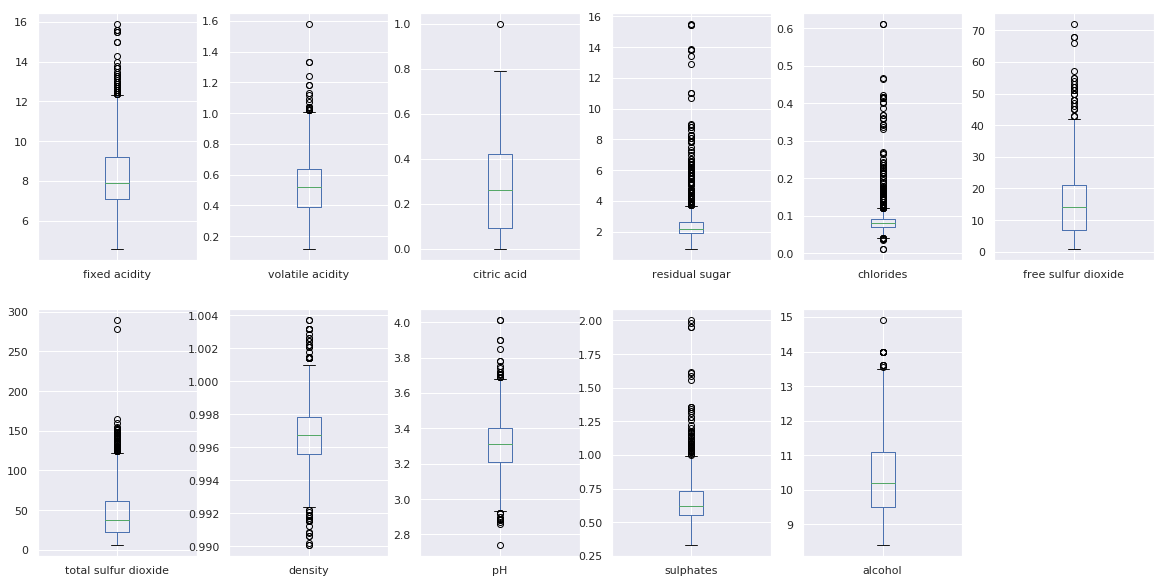

In [7]:
print('Almost the same thing again, this time graphically:')
wines_df.plot.box(subplots=True, layout=(2, 6), figsize=(20, 10));

There seem to be several outliers, I will get back to them soon.

Yet different perspective, feature histograms:


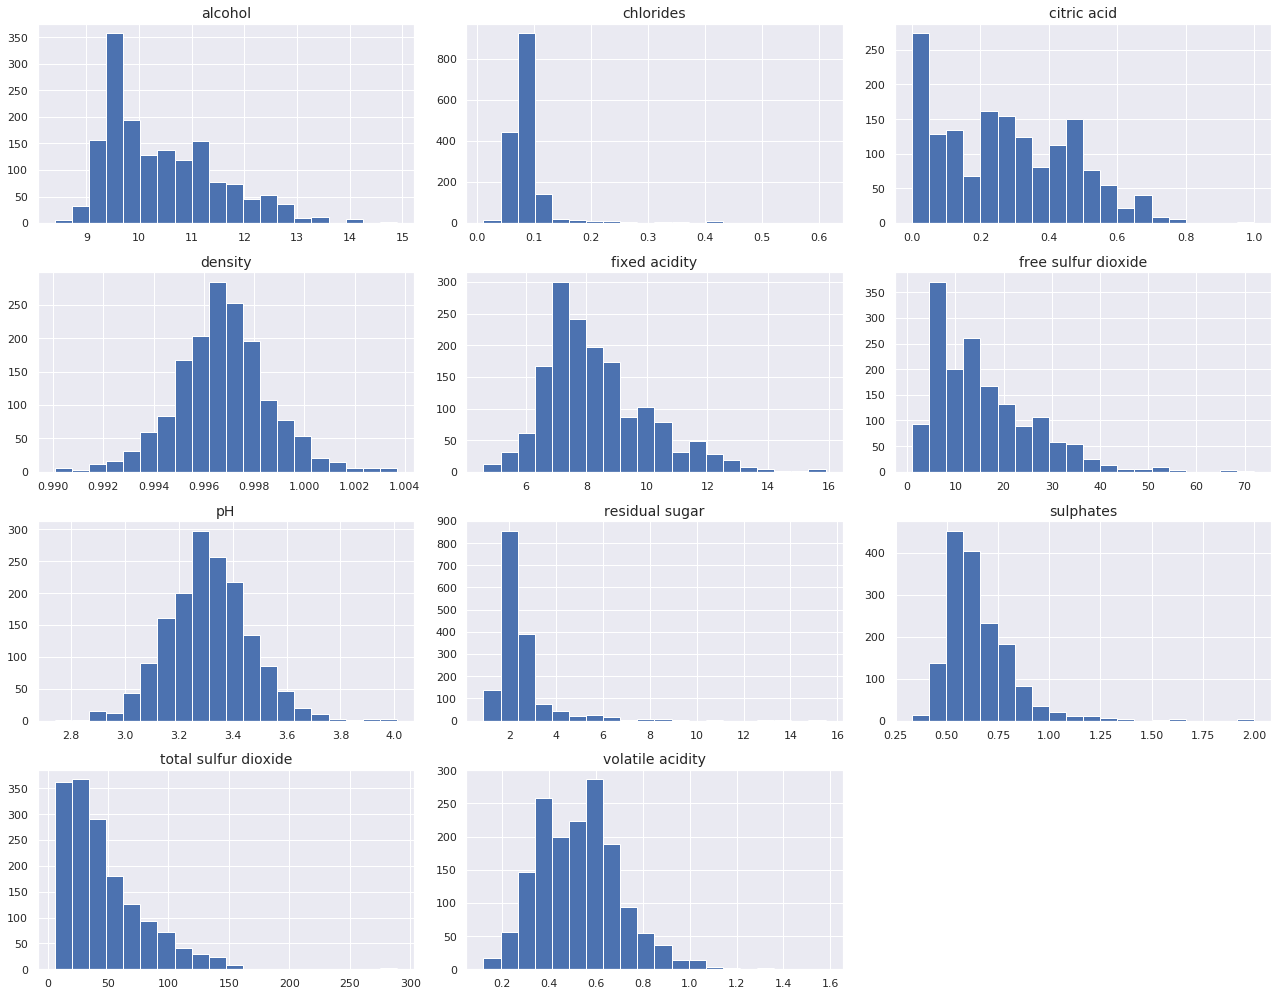

In [8]:
print('Yet different perspective, feature histograms:')
wines_df.hist(bins=20, figsize=(18, 14))
plt.tight_layout()

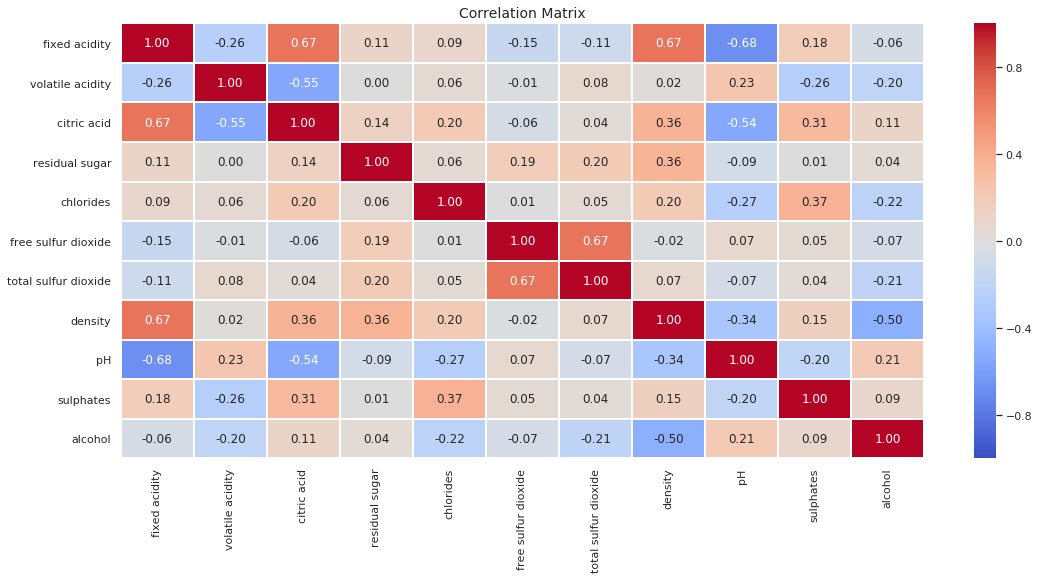

In [9]:
ax = sns.heatmap(
    wines_df.corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    fmt='0.2f',
    linewidths=1,
)
ax.set_title('Correlation Matrix');

### Training-testing split

Error estimates are more credible when done on "unseen" data, therefore, I will set aside randomly selected 30% of the data for testing. 

I will also make a separate training set with removed outliers for inspecting their role in the regression - how they skew the regression and influence generalization.
I will remove rows that contain a value more than 3 standard deviations in any of the columns.

In [10]:
train_df, test_df = sklearn.model_selection.train_test_split(
    wines_df,
    test_size=0.3,
    shuffle=True,
)

# zcore = (x - x.avg)/x.std
good_zscore = np.abs(scipy.stats.zscore(train_df)) <= 3
trim_index = good_zscore.all(axis=1) # all values in a row have good zscore
train_df_trimmed  = train_df[trim_index]

Splitting into inputs (explanatory features) and results (responses).

In [11]:
def xy_split(df):
    x_labels = wines_df.columns[:-1]
    y_label = wines_df.columns[-1]
    return df[x_labels], df[y_label]

x_train,      y_train      = xy_split(train_df)
x_train_trim, y_train_trim = xy_split(train_df_trimmed)
x_test,       y_test       = xy_split(test_df)

In [12]:
# a simple utility
def compare_distributions(
    title='Kernel densities (distribution) of response values',
    ax=None,
    kde=True,
    hist=False,
    **label_value_pairs
):
    for label, values in label_value_pairs.items():
        ax = sns.distplot(
            values,
            kde=kde,
            hist=hist,
            label=label,
            ax=ax,
            axlabel=False
        )
        
    if title: ax.set_title(title)
    # if hist it won't set the legend automatically
    if hist: ax.legend(label_value_pairs.keys())
    
    return ax

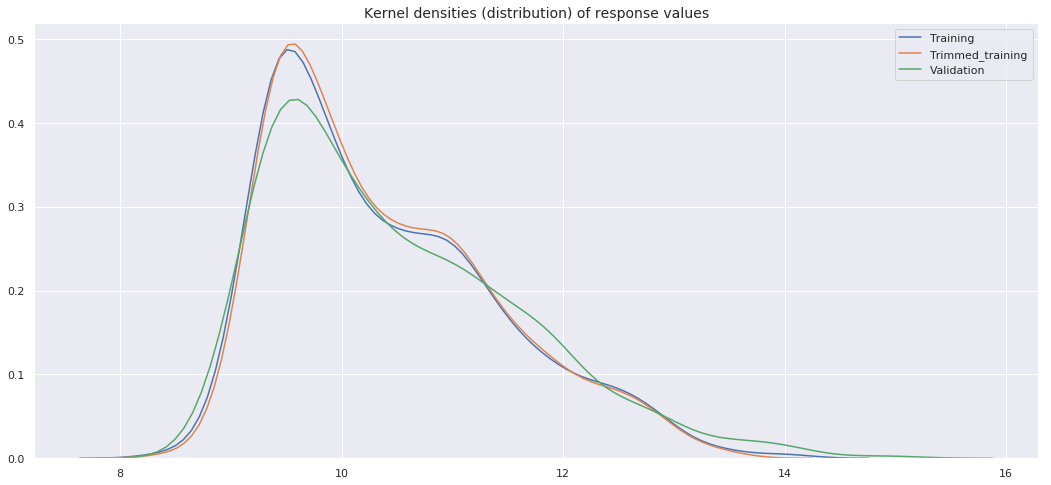

In [13]:
# ordinary histogram would be quite confusing...
compare_distributions(
    Training=y_train,
    Trimmed_training=y_train_trim,
    Validation=y_test
);

Training data:


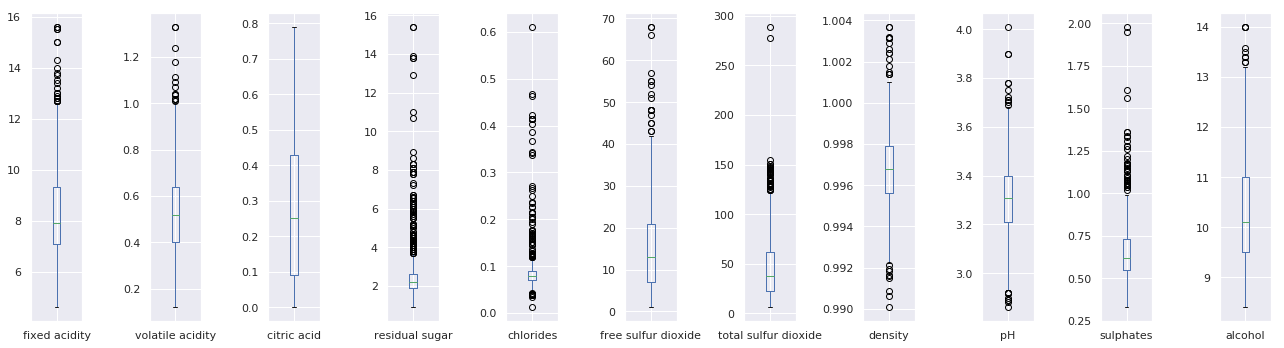

In [14]:
print('Training data:')
train_df.plot.box(subplots=True, figsize=(18,5))
plt.tight_layout()

Testing data:


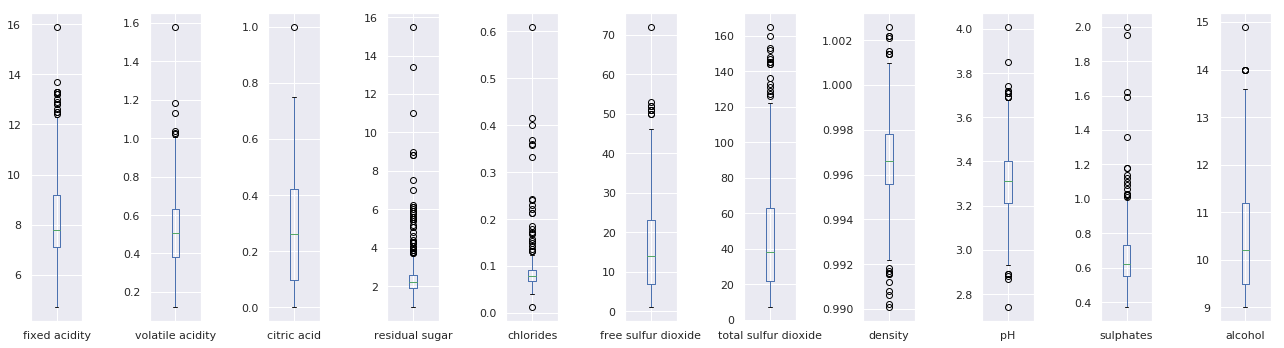

In [15]:
print('Testing data:')
test_df.plot.box(subplots=True, figsize=(18,5))
plt.tight_layout()

### Model

The model and regression method are perhaps the simplest possible - i.e. a multilinear model
$\theta_0 + \theta_1 a_1 + \theta_2 a_2 + \dots + \theta_n a_n$
where $a_i$ is the $i$-th attribute (explanatory feature) and $\theta_i, i \in \{0, 1, \dots, n\}$
are the regression coefficients obtained using the least squares method.

If the data has unit variance and zero mean, the absolute value of the resulting coefficients can be
interpreted as the "importance/usefulness" of the corresponding attribute for the problem.
Therefore, I will shift and scale the training data accordingly.

<em>Note: it does not really matter whether the response (results) column is normalized.
If it is not, then the regression coefficients will be multiplied by the standard deviation
of the response column and intercept (the constant term) will be its mean.
I find working with the original values easier in this case (less to worry about).</em>

In [16]:
# some utils

def print_regr_coefs(lin_reg):
    print(f'Intercept: {lin_reg.intercept_:.3f}')
    print('Coefs:', lin_reg.coef_)
    
def print_metrics(y_true, y_pred, comment=None, show_dists=True):
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    desc = f'MAE: {mae:.3f}  MSE: {mse:.3f}  R2: {r2:.3f}'
    if comment:
        desc += f'  [{comment}]'
        
    if show_dists:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 3))
        fig.suptitle(desc)
        
        residuals = (y_true - y_pred).values
        abs_residuals = np.abs(residuals)
        
        # distribution of residuals
        sns.distplot(residuals, ax=ax1)
        sns.distplot(abs_residuals, ax=ax1)
        start = np.floor(min(residuals))
        end = np.ceil(max(abs_residuals))
        ax1.xaxis.set_ticks(np.round(np.linspace(start, end, 11),2))
        ax1.legend(['Residuals','Absolute residuals'])
        
        # dist. of response values
        compare_distributions(
            title=None,
            ax=ax2,
            hist=True,
            Measured=y_true,
            Predicted=y_pred,
        )
        plt.show()
    else:
        print(desc)
    
    
def test_report(y_true, y_pred):
    err_df = pd.DataFrame()
    err_df['measured'] = y_true
    err_df['predicted'] = y_pred
    err_df['residual'] = err_df.measured - err_df.predicted
    err_df['abs_residual'] = np.abs(err_df.residual)

    # show statistics
    print('Response statistics:')
    IPython.display.display(err_df.describe())
    
    ## plot results and residuals
    # true vs. predicted
    ax1 = plt.subplot(1,2,1)
    ax1.set_title('Measured values vs. predicted')
    ax1.plot(y_pred, y_pred)
    err_df.plot.scatter('measured', 'predicted', c='orange', ax=ax1)
    
    # residuals 
    ax2 = plt.subplot(1,2,2)
    ax2.set_title('Residuals')
    # y=0 line
    x_infimum = np.floor(err_df.measured.min())
    x_supremum = np.ceil(err_df.measured.max())
    ax2.plot([x_infimum, x_supremum], [0, 0])
    err_df.plot.scatter('measured', 'residual', c='orange', ax=ax2)

    plt.tight_layout()
    plt.show()

Regressing on all features, whole training set

Intercept: 10.396
Coefs: [0.904 0.076 0.170 0.397 -0.086 -0.025 -0.076 -1.118 0.571 0.200]


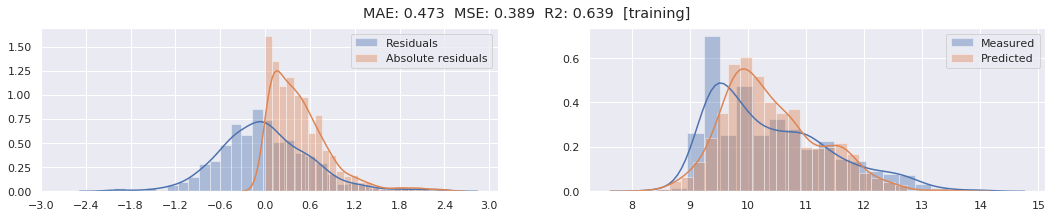

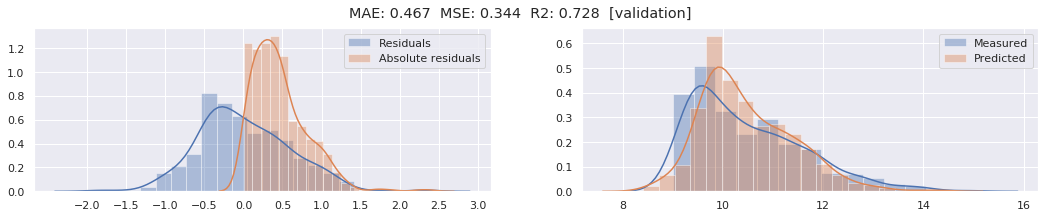


Response statistics:


,measured,predicted,residual,abs_residual
count,480.000,480.000,480.000,480.000
mean,10.485,10.478,0.007,0.467
std,1.125,0.925,0.587,0.354
min,9.000,8.408,-1.904,0.001
25%,9.500,9.819,-0.398,0.203
50%,10.200,10.284,-0.059,0.397
75%,11.200,11.084,0.389,0.648
max,14.900,14.378,2.388,2.388


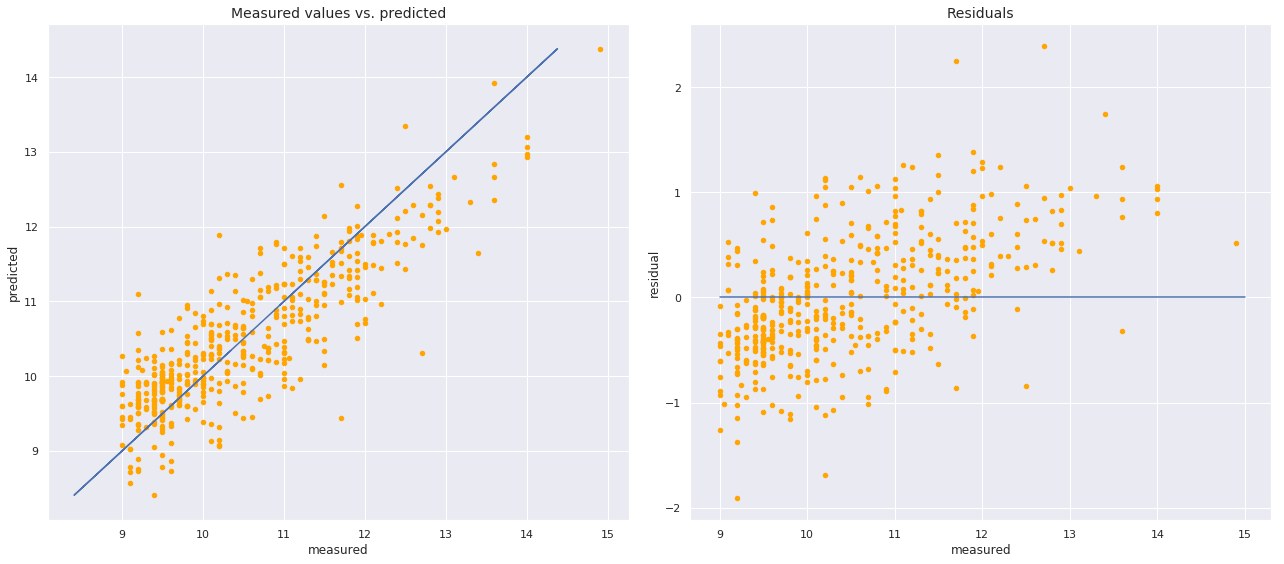

In [17]:
print('Regressing on all features, whole training set\n')

# scaling
x_scaler = sklearn.preprocessing.StandardScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_train_trim_scaled = x_scaler.transform(x_train_trim)
x_test_scaled = x_scaler.transform(x_test)

# regression
reg = LinearRegression().fit(x_train_scaled, y_train)

# reports
print_regr_coefs(reg)

y_pred_train = reg.predict(x_train_scaled)
print_metrics(y_train, y_pred_train, 'training')

y_pred_test = reg.predict(x_test_scaled)
print_metrics(y_test, y_pred_test, 'validation')
print()
test_report(y_test, y_pred_test)

The mean average error (same as mean absolute residual) tells us
that the model is on average off by 0.48% off from the actual percentual content of the alcohol,
considering that the range of the alcohol volume is 8.4% - 14.9%,
this can be translated to about 7.4% relative error.
From the "Response statistics" table, based on the quantiles of absolute residual,
we can see that a quarter of the results are predicted within 0.2% (absolute error),
half of them within 0.4%, three quarters only within 0.7%
and the worst error is 2.4% off.

In [18]:
print('Features by "importance" for the last regression:')
coef_df = pd.DataFrame()
coef_df['feature'] = x_train.columns
coef_df['coef'] = reg.coef_
coef_df['abs_coef'] = abs(coef_df['coef'])
coef_df['natural_coef'] = x_scaler.inverse_transform(reg.coef_)
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df.reset_index(drop=True, inplace=True)
coef_df

Features by "importance" for the last regression:


,feature,coef,abs_coef,natural_coef
0,density,-1.118,1.118,0.995
1,fixed acidity,0.904,0.904,9.912
2,pH,0.571,0.571,3.395
3,residual sugar,0.397,0.397,3.093
4,sulphates,0.200,0.200,0.690
5,citric acid,0.170,0.170,0.305
6,chlorides,-0.086,0.086,0.083
7,total sulfur dioxide,-0.076,0.076,43.908
8,volatile acidity,0.076,0.076,0.543
9,free sulfur dioxide,-0.025,0.025,15.461


In [19]:
# I will leave this here, perhaps I had too long weekend...
print('Formula for estimating alcohol content in red wine:')
print('(features by contribution, no need to scale)')
IPython.display.Math(
    r'\begin{align}' +
    r'{:.3f}\ &+\ '.format(reg.intercept_) + 
    ''.join([
        r'\\& {:+.3f} \cdot [\verb|{}|]'.format(coef, ftr)
        for coef, ftr in coef_df[['natural_coef', 'feature']].values
    ]) +
    r'\end{align}'
)

Formula for estimating alcohol content in red wine:
(features by contribution, no need to scale)


<IPython.core.display.Math object>

## Conclusion

I experimented with leaving some columns and with the threshold for trimming outliers,
the results were, however, insignificant and inconsistent, so I won't clutter the notebook
with examples of those, I will just leave one quite general cell for quickly playing
with  these adjustments (just comment out columns, change training set, etc.).

This approximation method is trying to minimize the MSE metric.
In my opinion, it would be better to minimize error so that it favors
the majority of the data and not being influenced much by edge cases.

Intercept: 10.397
Coefs: [-1.051 0.822 0.491 0.382 0.174 0.152 0.058 0.001 -0.089 0.008]


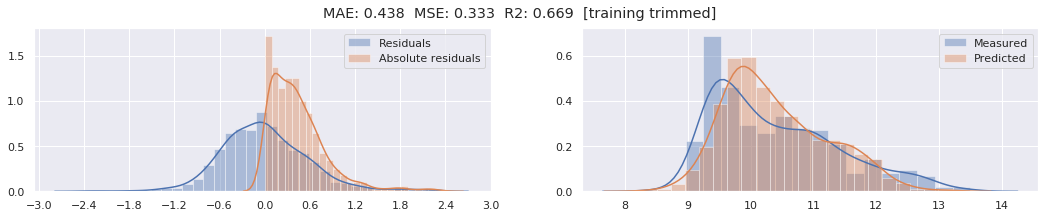

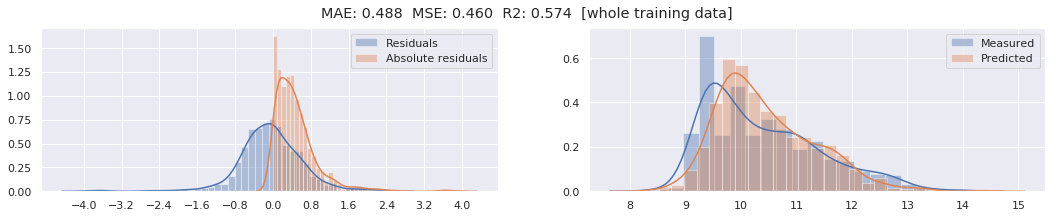

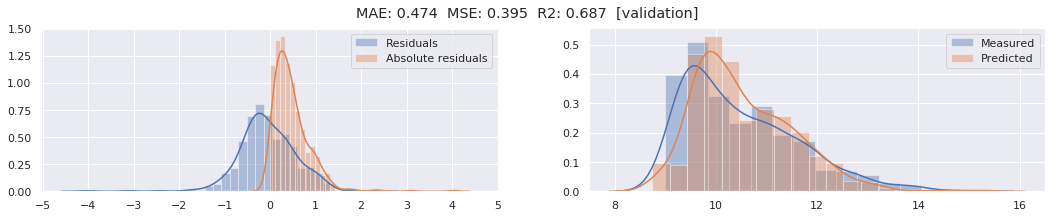


Response statistics:


,measured,predicted,residual,abs_residual
count,480.000,480.000,480.000,480.000
mean,10.485,10.537,-0.052,0.474
std,1.125,0.968,0.627,0.413
min,9.000,8.747,-4.038,0.001
25%,9.500,9.802,-0.420,0.204
50%,10.200,10.318,-0.098,0.378
75%,11.200,11.178,0.320,0.641
max,14.900,15.254,2.271,4.038


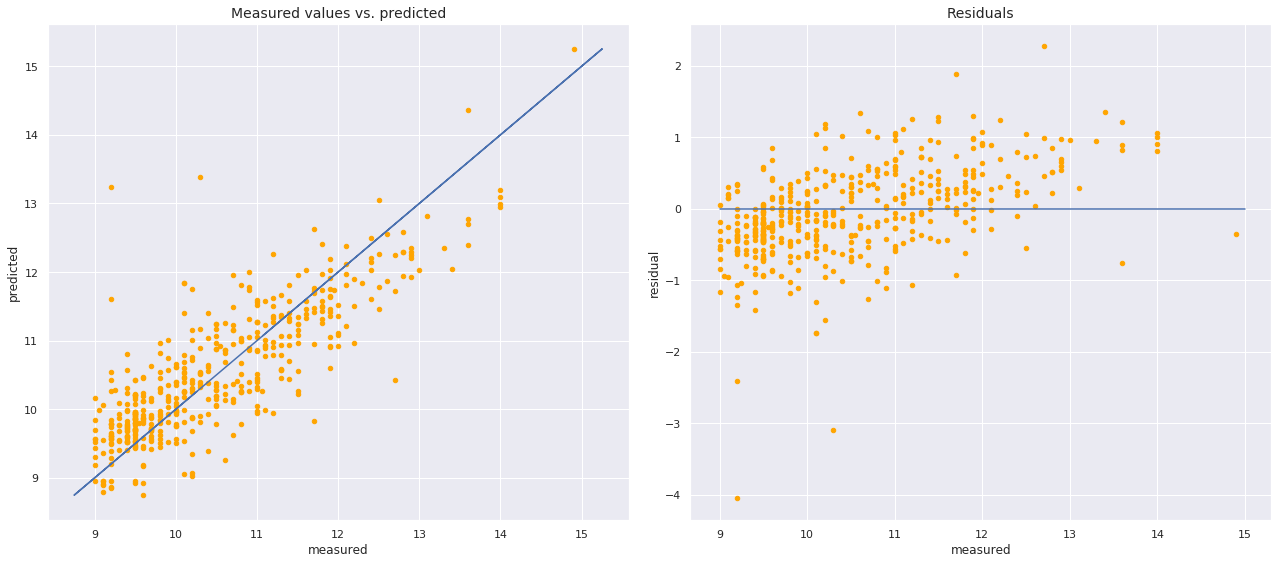

In [20]:
### tinkering cell ###

# scaling
columns = [
    'density',
    'fixed acidity',
    'pH',
    'residual sugar',
    'sulphates',
    'citric acid',
    'volatile acidity',
    'chlorides',
    'total sulfur dioxide',
    'free sulfur dioxide'
]
x_scaler = sklearn.preprocessing.StandardScaler()
x_scaler.fit(x_train_trim[columns])
x_train_scaled = x_scaler.transform(x_train[columns])
x_train_trim_scaled = x_scaler.transform(x_train_trim[columns])
x_test_scaled = x_scaler.transform(x_test[columns])

# regression
reg = LinearRegression().fit(x_train_trim_scaled, y_train_trim)
# reg.intercept_ = 10.2

# reports
print_regr_coefs(reg)

y_pred_train_trim = reg.predict(x_train_trim_scaled)
print_metrics(y_train_trim, y_pred_train_trim, 'training trimmed')

y_pred_train = reg.predict(x_train_scaled)
print_metrics(y_train, y_pred_train, 'whole training data')

y_pred_test = reg.predict(x_test_scaled)
print_metrics(y_test, y_pred_test, 'validation')
print()
test_report(y_test, y_pred_test)